# Objective

- Predict which team will win head to head match up based on schedule and team strength

- Schedule will determine the amount of rest each team gets, the distance traveled, and home court advantage

- Team strength is cumulative sum of individual players' offensive and defensive rating based on contribution to total possession by season

- 2020-21 will be used as test data to see the accuracy of the model

# Initial Setup

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [56]:
# import league schedule data
team_game_schedule = pd.read_csv("league_game_log.csv", index_col=0)
team_game_schedule.columns = [x.lower() for x in team_game_schedule.columns]

# convert game_date to date format
team_game_schedule["game_date"] = team_game_schedule["game_date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d").date()
)

# indicate home vs away based on matchup string
team_game_schedule["home_away"] = team_game_schedule["matchup"].apply(
    lambda x: "away" if "@" in x else "home"
)

In [57]:
# since pre 1985-86 has a lot of missing information such as dreb, oreb, ast, blk, use 85-86 and after
seasons = []
for i in range(1985, 2021):
    seasons.append(str(i) + "-" + str(i + 1)[-2:])

team_game_schedule = team_game_schedule[team_game_schedule["season"].isin(seasons)]

team_schedule_columns = [
    "season",
    "game_date",
    "game_id",
    "team_id",
    "team_abbreviation",
    "team_name",
    "matchup",
    "home_away",
    "wl",
    "min",
    "pts",
    "fgm",
    "fga",
    "fg3m",
    "fg3a",
    "ftm",
    "fta",
    "oreb",
    "dreb",
    "ast",
    "tov",
    "stl",
    "blk",
    "pf",
]


team_game_schedule = team_game_schedule[team_schedule_columns]


# fix the issue where some games the minutes would be sum of all 5 player minutes
## ex. instead of 48 mins, 240 mins

team_game_schedule["min"] = np.where(
    team_game_schedule["min"] > 100,
    team_game_schedule["min"] / 5,
    team_game_schedule["min"],
)


team_game_schedule

,season,game_date,game_id,team_id,team_abbreviation,team_name,matchup,home_away,wl,min,...,fg3a,ftm,fta,oreb,dreb,ast,tov,stl,blk,pf
0,1985-86,1985-10-25,28500005,1610612764,WAS,Washington Bullets,WAS @ ATL,away,W,48.0,...,2.0,20,26,11.0,29.0,21.0,17.0,11.0,7.0,19.0
1,1985-86,1985-10-25,28500005,1610612737,ATL,Atlanta Hawks,ATL vs. WAS,home,L,48.0,...,3.0,9,18,16.0,28.0,25.0,16.0,8.0,5.0,23.0
2,1985-86,1985-10-25,28500008,1610612744,GOS,Golden State Warriors,GOS vs. DEN,home,L,48.0,...,4.0,33,52,18.0,29.0,17.0,28.0,3.0,7.0,37.0
3,1985-86,1985-10-25,28500008,1610612743,DEN,Denver Nuggets,DEN @ GOS,away,W,48.0,...,3.0,34,43,13.0,31.0,26.0,22.0,11.0,3.0,40.0
4,1985-86,1985-10-25,28500010,1610612765,DET,Detroit Pistons,DET vs. MIL,home,W,48.0,...,1.0,40,49,17.0,40.0,23.0,22.0,11.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2020-21,2021-05-16,22001079,1610612754,IND,Indiana Pacers,IND @ TOR,away,W,48.0,...,37.0,14,18,10.0,37.0,34.0,13.0,8.0,3.0,19.0
2156,2020-21,2021-05-16,22001074,1610612760,OKC,Oklahoma City Thunder,OKC vs. LAC,home,W,48.0,...,26.0,9,16,14.0,40.0,20.0,15.0,1.0,12.0,11.0
2157,2020-21,2021-05-16,22001074,1610612746,LAC,LA Clippers,LAC @ OKC,away,L,48.0,...,43.0,12,15,16.0,28.0,17.0,3.0,8.0,3.0,14.0
2158,2020-21,2021-05-16,22001072,1610612747,LAL,Los Angeles Lakers,LAL @ NOP,away,W,48.0,...,35.0,9,15,8.0,34.0,30.0,10.0,14.0,5.0,16.0


In [58]:
# import team geo location coordinates
team_history = pd.read_csv("team_history.csv", index_col=0)
team_history.columns = [x.lower() for x in team_history.columns]

team_history = team_history.rename(columns={"id": "team_id"})
team_history["team_name"] = team_history["city"] + " " + team_history["nickname"]

team_history = team_history[["team_id", "team_name", "lat", "long"]]
team_history = team_history.drop_duplicates(subset=["team_id", "team_name"])
clippers_adj = {
    "team_id": 1610612746,
    "team_name": "LA Clippers",
    "lat": 34.0522,
    "long": 118.2437,
}

team_history = team_history.append(clippers_adj, ignore_index=True)
team_history

,team_id,team_name,lat,long
0,1610612737,Atlanta Hawks,33.7490,84.3880
1,1610612737,St. Louis Hawks,38.6270,90.1994
2,1610612737,Milwaukee Hawks,43.0389,87.9065
3,1610612737,Tri-Cities Blackhawks,46.2350,119.2233
4,1610612738,Boston Celtics,42.3601,71.0589
5,1610612739,Cleveland Cavaliers,41.4993,81.6944
6,1610612740,New Orleans Pelicans,29.9511,90.0715
7,1610612740,New Orleans Hornets,29.9511,90.0715
8,1610612740,New Orleans/Oklahoma City Hornets,35.4676,97.5164
9,1610612741,Chicago Bulls,41.8781,87.6298


In [59]:
# calculcate distance travelled based on coordinates
from math import radians, cos, sin, asin, sqrt


def distance(lat1, lat2, lon1, lon2):

    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    c = 2 * asin(sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 3956

    return c * r

# Data Cleaning

In [60]:
team_game_analysis = team_game_schedule[
    [
        "season",
        "game_date",
        "game_id",
        "team_id",
        "team_abbreviation",
        "team_name",
        "home_away",
        "wl",
        "matchup",
    ]
]

team_game_analysis = team_game_analysis.sort_values(
    ["season", "team_abbreviation", "game_date"]
)
team_game_analysis

# select first game by season by team, where the days rest will always be 10 days for the first game
first_game = (
    team_game_analysis.groupby(["season", "team_abbreviation", "team_id"])
    .first()
    .reset_index()
)
first_game = first_game[["season", "team_abbreviation", "team_id", "game_date"]]
first_game["first_game"] = 1


schedule_geo = team_game_analysis.merge(
    team_history, on=["team_id", "team_name"], how="left"
)

schedule_geo = schedule_geo.rename(columns={"lat": "home_lat", "long": "home_long"})


schedule_geo = schedule_geo.merge(
    first_game, on=["season", "team_abbreviation", "team_id", "game_date"], how="left"
)

schedule_geo["first_game"] = schedule_geo["first_game"].fillna(0)


# subtract days of current game - prev game days. If first game of the season, 10 days of rest
# shift(1) = previous shift(-1) = next
schedule_geo["team_days_rest"] = np.where(
    (schedule_geo["team_id"].shift(1) == schedule_geo["team_id"])
    & (schedule_geo["first_game"] == 0),
    (schedule_geo["game_date"] - schedule_geo["game_date"].shift(1)).dt.days - 1,
    10,
)

schedule_geo = schedule_geo.sort_values(["season", "game_id", "game_date"])

# add opponent information based on game_id
for column in schedule_geo:
    schedule_geo["opp_" + str(column)] = np.where(
        # next game_id matches current team_id
        schedule_geo["game_id"].shift(-1) == schedule_geo["game_id"],
        # add next row to current
        schedule_geo[column].shift(-1),
        # else add previous row to current
        schedule_geo[column].shift(1),
    )

schedule_geo = schedule_geo.sort_values(
    [
        "season",
        "team_abbreviation",
        "team_id",
    ]
)


# add distance travel based on location of previous game
schedule_geo["prev_lat"] = np.where(
    (schedule_geo["team_id"].shift(1) == schedule_geo["team_id"])
    & (schedule_geo["home_away"].shift(1) == "away"),
    schedule_geo["opp_home_lat"].shift(1),
    schedule_geo["home_lat"],
)

schedule_geo["prev_long"] = np.where(
    (schedule_geo["team_id"].shift(1) == schedule_geo["team_id"])
    & (schedule_geo["home_away"].shift(1) == "away"),
    schedule_geo["opp_home_long"].shift(1),
    schedule_geo["home_long"],
)


schedule_geo["team_distance_travelled"] = schedule_geo.apply(
    lambda x: distance(x["home_lat"], x["prev_lat"], x["home_long"], x["prev_long"])
    if x["home_away"] == "home"
    else distance(x["opp_home_lat"], x["prev_lat"], x["opp_home_long"], x["prev_long"]),
    axis=1,
)


schedules = schedule_geo[
    [
        "season",
        "game_date",
        "game_id",
        "team_id",
        "team_abbreviation",
        "team_name",
        "home_away",
        "wl",
        "home_lat",
        "home_long",
        "first_game",
        "team_days_rest",
        "team_distance_travelled",
    ]
].sort_values(["season", "game_date", "game_id"])


schedules_column = schedules.columns.tolist()

# add opponent information based on game_id
for column in schedules_column:
    schedules["opp_" + str(column)] = np.where(
        # next game_id matches current team_id
        schedules["game_id"].shift(-1) == schedules["game_id"],
        # add next row to current
        schedules[column].shift(-1),
        # else add previous row to current
        schedules[column].shift(1),
    )

schedules_final = schedules.sort_values(["season", "game_date", "game_id"])
schedules_final = (
    schedules_final.groupby(["season", "game_date", "game_id"]).first().reset_index()
)

schedules_final = schedules_final[
    [
        "season",
        "game_date",
        "game_id",
        "team_id",
        "team_abbreviation",
        "team_name",
        "home_away",
        "wl",
        "first_game",
        "team_days_rest",
        "team_distance_travelled",
        "opp_team_id",
        "opp_team_abbreviation",
        "opp_team_name",
        "opp_home_away",
        "opp_first_game",
        "opp_team_days_rest",
        "opp_team_distance_travelled",
    ]
]

# if team 1 wins 1 else 0
schedules_final["winner"] = schedules_final.apply(
    lambda x: 1 if x["wl"] == "W" else 0,
    axis=1,
)

# if team 1 was home then 1 else 0
schedules_final["winner_home_court"] = schedules_final.apply(
    lambda x: 1 if (x["home_away"] == "home") else 0,
    axis=1,
)

schedules_final = schedules_final.rename(
    columns={
        "team_id": "team1_id",
        "team_abbreviation": "team1_abbreviation",
        "team_name": "team1_name",
        "home_away": "team1_homeaway",
        "first_game": "team1_first_game",
        "team_days_rest": "team1_days_rest",
        "team_distance_travelled": "team1_distance_travelled",
        "opp_team_id": "team2_id",
        "opp_team_abbreviation": "team2_abbreviation",
        "opp_team_name": "team2_name",
        "opp_home_away": "team2_homeaway",
        "opp_first_game": "team2_first_game",
        "opp_team_days_rest": "team2_days_rest",
        "opp_team_distance_travelled": "team2_distance_travelled",
    }
)

schedules_final

,season,game_date,game_id,team1_id,team1_abbreviation,team1_name,team1_homeaway,wl,team1_first_game,team1_days_rest,team1_distance_travelled,team2_id,team2_abbreviation,team2_name,team2_homeaway,team2_first_game,team2_days_rest,team2_distance_travelled,winner,winner_home_court
0,1985-86,1985-10-25,28500004,1610612738,BOS,Boston Celtics,away,L,1.0,10.0,235.505411,1.610613e+09,NJN,New Jersey Nets,home,1.0,10.0,0.000000,0,0
1,1985-86,1985-10-25,28500005,1610612737,ATL,Atlanta Hawks,home,L,1.0,10.0,0.000000,1.610613e+09,WAS,Washington Bullets,away,1.0,10.0,541.914409,0,1
2,1985-86,1985-10-25,28500006,1610612746,LAC,Los Angeles Clippers,away,W,1.0,10.0,361.192935,1.610613e+09,SAC,Sacramento Kings,home,1.0,10.0,0.000000,1,0
3,1985-86,1985-10-25,28500007,1610612741,CHI,Chicago Bulls,home,W,1.0,10.0,0.000000,1.610613e+09,CLE,Cleveland Cavaliers,away,1.0,10.0,307.087672,1,1
4,1985-86,1985-10-25,28500008,1610612743,DEN,Denver Nuggets,away,W,1.0,10.0,946.622989,1.610613e+09,GOS,Golden State Warriors,home,1.0,10.0,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41077,2020-21,2021-05-16,22001076,1610612743,DEN,Denver Nuggets,away,L,0.0,1.0,1962.960683,1.610613e+09,POR,Portland Trail Blazers,home,0.0,2.0,1004.107703,0,0
41078,2020-21,2021-05-16,22001077,1610612758,SAC,Sacramento Kings,home,L,0.0,1.0,0.000000,1.610613e+09,UTA,Utah Jazz,away,0.0,1.0,1335.214853,0,1
41079,2020-21,2021-05-16,22001078,1610612756,PHX,Phoenix Suns,away,W,0.0,0.0,0.000000,1.610613e+09,SAS,San Antonio Spurs,home,0.0,0.0,0.000000,1,0
41080,2020-21,2021-05-16,22001079,1610612754,IND,Indiana Pacers,away,W,0.0,0.0,417.900582,1.610613e+09,TOR,Toronto Raptors,home,0.0,1.0,1202.513604,1,0


In [61]:
# import nba player career data
career_info = pd.read_csv("player_stats_career.csv", index_col=0)
career_info = career_info[
    [
        "player_id",
        "player_name",
        "season_id",
        "team_id",
        "team_abbreviation",
        "player_age",
        "gp",
        "min",
        "pts",
        "fgm",
        "fga",
        "fg_pct",
        "fg3m",
        "fg3a",
        "fg3_pct",
        "ftm",
        "fta",
        "ft_pct",
        "ast",
        "tov",
        "oreb",
        "dreb",
        "reb",
        "blk",
        "stl",
        "pf"
    ]
]
career_info = career_info.rename(
    columns={
        "season_id": "season",
    }
)



In [62]:
# remove any seasons pre-1985-86 seasons
player_career_info = career_info[career_info["season"].isin(seasons)]


# remove any values with tot
player_career_info = player_career_info[
    player_career_info["team_abbreviation"] != "TOT"
]

player_career_info.sort_values("season")

,player_id,player_name,season,team_id,team_abbreviation,player_age,gp,min,pts,fgm,...,fta,ft_pct,ast,tov,oreb,dreb,reb,blk,stl,pf
21017,78390,Terry Tyler,1985-86,1610612758,SAC,29.0,71,1651.0,674,295,...,112,0.750,94,94.0,109.0,204.0,313,108.0,64.0,159
13364,77481,Bill Martin,1985-86,1610612754,IND,23.0,66,691.0,332,143,...,54,0.852,52,58.0,42.0,60.0,102,7.0,21.0,108
13234,77456,Pace Mannion,1985-86,1610612762,UTH,25.0,57,673.0,255,97,...,82,0.646,55,41.0,26.0,56.0,82,5.0,32.0,68
13186,77449,Moses Malone,1985-86,1610612755,PHL,31.0,74,2706.0,1759,571,...,784,0.787,90,261.0,339.0,533.0,872,71.0,67.0,194
13156,252,Karl Malone,1985-86,1610612762,UTH,22.0,81,2475.0,1203,504,...,405,0.481,236,279.0,174.0,544.0,718,44.0,105.0,295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15838,1629644,KZ Okpala,2020-21,1610612748,MIA,22.0,37,447.0,92,36,...,15,0.533,19,15.0,21.0,47.0,68,11.0,10.0,59
8115,1629750,Javonte Green,2020-21,1610612741,CHI,27.0,16,128.0,41,14,...,10,1.000,6,6.0,6.0,13.0,19,4.0,10.0,13
15857,203506,Victor Oladipo,2020-21,1610612754,IND,29.0,9,300.0,180,64,...,37,0.730,38,18.0,1.0,50.0,51,2.0,15.0,23
15835,1630171,Isaac Okoro,2020-21,1610612739,CLE,20.0,67,2173.0,646,235,...,157,0.726,128,86.0,68.0,138.0,206,24.0,62.0,185


# Formulas to Calculate Individual Offensive Rating and Defensive Rating

In [63]:
# measures how proficient a player is on 3-point shots
def threept_proficiency(threepa, threepercent):
    threepro = (2 / (1 + np.exp(-threepa)) - 1) * threepercent
    return threepro


# an estimate for the number of open shots created for teammates (per 100 possessions)
def box_creation(assist, points, turnovers, threept_proficiency):
    box = (
        (assist * 0.1843)
        + (points + turnovers) * 0.0969
        - 2.3021 * (threept_proficiency)
        + 0.0582 * (assist * (points + turnovers) * threept_proficiency)
        - 1.1942
    )
    return box


# percentage of of possessions where a player is "directly involved" in a scoring attempt or turnover
def offensiveload(assist, box_creation, fga, fta, turnovers):
    OL = (
        (assist - (0.38 * box_creation) * 0.75)
        + fga
        + fta * 0.44
        + box_creation
        + turnovers
    )
    return OL


# create functions to generate ortg, drtg


def scposs(
    fg_part,
    ast_part,
    ft_part,
    team_oreb,
    team_sc_poss,
    team_oreb_weight,
    team_play_percent,
    oreb_part,
):
    scposs = (fg_part + ast_part + ft_part) * (
        1 - ((team_oreb / team_sc_poss) * team_oreb_weight * team_play_percent)
    ) + oreb_part
    return scposs


def team_sc_poss(team_fgm, team_ftm, team_fta):
    team_sc_poss = team_fgm + 0.4 * ((1 - (1 - (team_ftm / team_fta)) ** 2) * team_fta)
    return team_sc_poss


def team_oreb_weight(team_oreb_percent, team_play_percent):
    team_oreb_weight = ((1 - team_oreb_percent) * team_play_percent) / (
        ((1 - team_oreb_percent) * team_play_percent)
        + (team_oreb_percent * (1 - team_play_percent))
    )
    return team_oreb_weight


def fg_part(fgm, pts, ftm, fga, qast):
    fg_part = fgm * (1 - (((0.5 * (pts - ftm)) / (2 * fga)) * qast))
    return fg_part


def qast(mp, team_mp, team_ast, ast, team_fgm, fgm):
    qast = (mp / (team_mp)) * (1.14 * ((team_ast - ast) / team_fgm)) + (
        (1 - (mp / team_mp))
        * ((team_ast / (team_mp * 5) * mp * 5) - ast)
        / ((team_fgm / (team_mp * 5) * mp * 5) - fgm)
    )
    return qast


def ast_part(ast, team_pts, team_ftm, pts, ftm, team_fga, fga):
    first = team_pts - team_ftm
    second = pts - ftm
    third = 4 * (team_fga - fga)
    fourth = ast
    ast_part = ((first - second) / third) * fourth
    return ast_part


def ft_part(ftm, fta):
    ft_part = (1 - (1 - (ftm / fta)) ** 2) * 0.4 * fta
    return ft_part


def team_play_percent(team_sc_poss, team_fga, team_fta, team_tov):
    team_play_percent = (team_sc_poss) / (team_fga + (team_fta * 0.4) + team_tov)
    return team_play_percent


def oreb_part(oreb, team_oreb_weight, team_play_percent):
    oreb_part = oreb * team_oreb_weight * team_play_percent
    return oreb_part


def team_oreb_percent(team_oreb, opp_team_dreb):
    team_oreb_percent = team_oreb / (team_oreb + opp_team_dreb)
    return team_oreb_percent


def fgxposs(fga, fgm, team_oreb_percent):
    fgxposs = (fga - fgm) * (1 - 1.07 * team_oreb_percent)
    return fgxposs


def ftxposs(ft_pct, fta):
    ftxposs = ((1 - ft_pct) ** 2) * fta * 0.4
    return ftxposs


def tot_poss(sc_poss, fgxposs, ftxposs, tov):
    tot_poss = sc_poss + fgxposs + ftxposs + tov
    return tot_poss


def pprod(
    pprod_fg,
    pprod_ast,
    pprod_ft,
    team_oreb,
    team_sc_poss,
    team_oreb_weight,
    team_play_percent,
    pprod_oreb,
):
    pprod = (pprod_fg + pprod_ast + pprod_ft) * (
        1 - ((team_oreb / team_sc_poss) * team_oreb_weight * team_play_percent)
    ) + pprod_oreb
    return pprod


def pprod_fg(fgm, fg3m, pts, ftm, fga, qast):
    first = (fgm + (0.5 * fg3m)) * 2
    second = (pts - ftm) / (4 * fga)
    third = qast
    fourth = 1 - (second * third)
    pprod_fg = first * fourth
    return pprod_fg


def pprod_ast(
    team_fgm, fgm, team_fg3m, fg3m, team_pts, team_ftm, pts, ftm, team_fga, fga, ast
):
    first = team_fgm - fgm
    second = team_fg3m - fg3m
    third = team_pts - team_ftm
    fourth = pts - ftm
    fifth = team_fga - fga
    firsteq = (first + 0.5 * second) / first
    secondeq = (third - fourth) / (2 * fifth)
    pprod_ast = firsteq * secondeq * ast
    return pprod_ast


def pprod_oreb(
    oreb, team_oreb_weight, team_play_percent, team_pts, team_fgm, team_ftm, team_fta
):
    first = oreb * team_oreb_weight * team_play_percent
    second = 1 - ((1 - team_ftm / team_fta) ** 2)
    third = second * 0.4 * team_fta
    fourth = team_pts / (team_fgm + third)
    pprod_oreb = first * fourth
    return pprod_oreb


def player_ortg(pprod, tot_poss):
    player_ortg = 100 * (pprod / tot_poss)
    return player_ortg


def fmwt(dfg_percent, dor_percent):
    fmwt = (dfg_percent * (1 - dor_percent)) / (
        (dfg_percent * (1 - dor_percent)) + ((1 - dfg_percent) * dor_percent)
    )
    return fmwt


def dor_percent(opp_oreb, team_dreb):
    dor_percent = opp_oreb / (opp_oreb + team_dreb)
    return dor_percent


def dfg_percent(opp_fgm, opp_fga):
    dfg_percent = opp_fgm / opp_fga
    return dfg_percent


def stop1(stl, blk, fmwt, dor_percent, dreb):
    stop1 = stl + (blk * fmwt * (1 - 1.07 * dor_percent)) + (dreb * (1 - fmwt))
    return stop1


def stop2(
    opp_fga,
    opp_fgm,
    team_blk,
    team_mp,
    fmwt,
    dor_percent,
    opp_tov,
    team_stl,
    mp,
    pf,
    team_pf,
    opp_fta,
    opp_ftm,
):
    first = (opp_fga - opp_fgm - team_blk) / (team_mp * 5)
    second = fmwt * mp * (1 - 1.07 * dor_percent) * first

    third = ((opp_tov - team_stl) / (team_mp * 5)) * mp
    fourth = 0.4 * (pf / team_pf) * opp_fta * (1 - (opp_ftm / opp_fta)) ** 2
    stop2 = second + third + fourth
    return stop2


def stops(stop1, stop2):
    stops = stop1 + stop2
    return stops


def team_poss(
    team_fga,
    team_fta,
    team_oreb,
    opp_dreb,
    team_fgm,
    team_tov,
    opp_fga,
    opp_fta,
    opp_oreb,
    team_dreb,
    opp_fgm,
    opp_tov,
):
    first = (
        team_fga
        + (0.4 * team_fta)
        - 1.07 * (team_oreb / (team_oreb + opp_dreb)) * (team_fga - team_fgm)
        + team_tov
    )

    second = (
        opp_fga
        + (0.4 * opp_fta)
        - 1.07 * (opp_oreb / (opp_oreb + team_dreb)) * (opp_fga - opp_fgm)
        + opp_tov
    )

    team_poss = (first + second) / 2

    return team_poss


def stop_percent(stops, opp_min, team_poss, mp):
    stop_percent = (stops * opp_min * 5) / (team_poss * mp)
    return stop_percent


def team_drtg(opp_pts, team_poss):
    team_drtg = 100 * (opp_pts / team_poss)
    return team_drtg


def d_pts_per_sc_poss(opp_pts, opp_fgm, opp_ftm, opp_fta):
    first = 1 - (1 - (opp_ftm / opp_fta)) ** 2
    second = opp_fta * 0.4
    third = opp_fgm + (first * second)
    d_pts_per_sc_poss = opp_pts / third
    return d_pts_per_sc_poss


def player_drtg(team_drtg, d_pts_per_sc_poss, stop_percent):
    player_drtg = team_drtg + 0.2 * (
        100 * d_pts_per_sc_poss * (1 - stop_percent) - team_drtg
    )
    return player_drtg

In [64]:
# group by game id, team, season and merge opponent information from the next row

team_schedule = (
    team_game_schedule.groupby(["game_id", "team_abbreviation", "team_id", "season"])[
        [
            "pts",
            "min",
            "fgm",
            "fga",
            "fg3m",
            "fg3a",
            "ftm",
            "fta",
            "oreb",
            "dreb",
            "ast",
            "tov",
            "blk",
            "stl",
            "pf",
        ]
    ]
    .sum()
    .reset_index()
)

team_schedule
team_schedule = team_schedule.rename(
    columns={
        "pts": "team_pts",
        "min": "team_min",
        "fgm": "team_fgm",
        "fga": "team_fga",
        "fg3m": "team_fg3m",
        "fg3a": "team_fg3a",
        "ftm": "team_ftm",
        "fta": "team_fta",
        "oreb": "team_oreb",
        "dreb": "team_dreb",
        "ast": "team_ast",
        "tov": "team_tov",
        "blk": "team_blk",
        "stl": "team_stl",
        "pf": "team_pf",
    }
)


team_schedule_columns = list(
    set(team_schedule.columns.tolist()) - set(["game_id", "season"])
)

for column in team_schedule_columns:
    team_schedule["opp_" + str(column)] = np.where(
        team_schedule["game_id"].shift(-1) == team_schedule["game_id"],
        team_schedule[column].shift(-1),
        team_schedule[column].shift(1),
    )

team_schedule = (
    team_schedule.groupby(["team_id", "team_abbreviation", "season"])[
        "team_pts",
        "team_min",
        "team_fgm",
        "team_fga",
        "team_fg3m",
        "team_fg3a",
        "team_ftm",
        "team_fta",
        "team_oreb",
        "team_dreb",
        "team_ast",
        "team_tov",
        "team_blk",
        "team_stl",
        "team_pf",
        "opp_team_pts",
        "opp_team_min",
        "opp_team_fgm",
        "opp_team_fga",
        "opp_team_fg3m",
        "opp_team_fg3a",
        "opp_team_ftm",
        "opp_team_fta",
        "opp_team_oreb",
        "opp_team_dreb",
        "opp_team_ast",
        "opp_team_tov",
        "opp_team_blk",
        "opp_team_stl",
        "opp_team_pf",
    ]
    .sum()
    .reset_index()
)

team_schedule

,team_id,team_abbreviation,season,team_pts,team_min,team_fgm,team_fga,team_fg3m,team_fg3a,team_ftm,...,opp_team_fg3a,opp_team_ftm,opp_team_fta,opp_team_oreb,opp_team_dreb,opp_team_ast,opp_team_tov,opp_team_blk,opp_team_stl,opp_team_pf
0,1610612737,ATL,1985-86,8906,3961.0,3447,7027.0,33,168.0,1979,...,282.0,1905.0,2507.0,1207.0,2324.0,1945.0,1476.0,371.0,697.0,2129.0
1,1610612737,ATL,1986-87,9024,3946.0,3435,7144.0,135,425.0,2019,...,426.0,1987.0,2598.0,1195.0,2276.0,1917.0,1294.0,385.0,619.0,2034.0
2,1610612737,ATL,1987-88,8844,3956.0,3443,7102.0,85,282.0,1873,...,407.0,1927.0,2480.0,1158.0,2349.0,1976.0,1287.0,352.0,640.0,2011.0
3,1610612737,ATL,1988-89,9102,3961.0,3412,7230.0,110,397.0,2168,...,511.0,1826.0,2329.0,1262.0,2311.0,2048.0,1450.0,353.0,687.0,2109.0
4,1610612737,ATL,1989-90,8901,3946.0,3417,7019.0,124,411.0,1943,...,533.0,1760.0,2279.0,1151.0,2236.0,2144.0,1244.0,389.0,672.0,1961.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,1610612766,CHH,1997-98,7923,3956.0,2968,6344.0,346,904.0,1641,...,1063.0,1436.0,1964.0,965.0,2259.0,1806.0,1240.0,372.0,582.0,1902.0
1023,1610612766,CHH,1998-99,4644,2430.0,1671,3718.0,268,735.0,1034,...,637.0,959.0,1306.0,655.0,1491.0,1092.0,762.0,232.0,443.0,1151.0
1024,1610612766,CHH,1999-00,8072,3956.0,2935,6533.0,339,1001.0,1863,...,1086.0,1347.0,1807.0,966.0,2550.0,1903.0,1297.0,421.0,604.0,2076.0
1025,1610612766,CHH,2000-01,7539,3976.0,2800,6501.0,340,984.0,1599,...,1081.0,1444.0,1910.0,892.0,2436.0,1748.0,1204.0,375.0,616.0,1768.0


In [65]:
# merge team data schedule with player data 

player_stats_total = player_career_info.merge(
    team_schedule,
    on=["team_id", "team_abbreviation", "season"],
    how="left",
)

player_stats_total

,player_id,player_name,season,team_id,team_abbreviation,player_age,gp,min,pts,fgm,...,opp_team_fg3a,opp_team_ftm,opp_team_fta,opp_team_oreb,opp_team_dreb,opp_team_ast,opp_team_tov,opp_team_blk,opp_team_stl,opp_team_pf
0,76001,Alaa Abdelnaby,1990-91,1610612757,POR,23.0,43,290.0,135,55,...,730.0,1819.0,2341.0,1079.0,2354.0,2048.0,1352.0,352.0,630.0,2075.0
1,76001,Alaa Abdelnaby,1991-92,1610612757,POR,24.0,71,934.0,432,178,...,805.0,1797.0,2367.0,1097.0,2336.0,1980.0,1317.0,433.0,688.0,1957.0
2,76001,Alaa Abdelnaby,1992-93,1610612749,MIL,25.0,12,159.0,64,26,...,783.0,1823.0,2437.0,1269.0,2398.0,2087.0,1446.0,456.0,773.0,1810.0
3,76001,Alaa Abdelnaby,1992-93,1610612738,BOS,25.0,63,1152.0,514,219,...,650.0,1749.0,2269.0,1094.0,2378.0,1971.0,1133.0,381.0,637.0,1676.0
4,76001,Alaa Abdelnaby,1993-94,1610612738,BOS,26.0,13,159.0,64,24,...,665.0,1673.0,2218.0,1131.0,2508.0,2089.0,1227.0,413.0,690.0,1738.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17704,1627826,Ivica Zubac,2017-18,1610612747,LAL,21.0,43,410.0,161,61,...,2469.0,1402.0,1843.0,840.0,2835.0,1932.0,1170.0,447.0,682.0,1679.0
17705,1627826,Ivica Zubac,2018-19,1610612747,LAL,22.0,33,516.0,281,112,...,2784.0,1459.0,1862.0,924.0,2918.0,2053.0,1167.0,421.0,683.0,1706.0
17706,1627826,Ivica Zubac,2018-19,1610612746,LAC,22.0,26,524.0,244,100,...,2477.0,1677.0,2159.0,925.0,2826.0,1976.0,1081.0,498.0,677.0,1969.0
17707,1627826,Ivica Zubac,2019-20,1610612746,LAC,23.0,72,1326.0,596,236,...,2566.0,1335.0,1766.0,771.0,2491.0,1709.0,1013.0,338.0,540.0,1647.0


In [66]:
# calculating offensive rating for individual players

player_stats_total["qast"] = qast(
    player_stats_total["min"],
    player_stats_total["team_min"],
    player_stats_total["team_ast"],
    player_stats_total["ast"],
    player_stats_total["team_fgm"],
    player_stats_total["fgm"],
)

player_stats_total["ast_part"] = ast_part(
    player_stats_total["ast"],
    player_stats_total["team_pts"],
    player_stats_total["team_ftm"],
    player_stats_total["pts"],
    player_stats_total["ftm"],
    player_stats_total["team_fga"],
    player_stats_total["fga"],
)


player_stats_total["ft_part"] = ft_part(
    player_stats_total["ftm"], player_stats_total["fta"]
)

player_stats_total["team_sc_poss"] = team_sc_poss(
    player_stats_total["team_fgm"],
    player_stats_total["team_ftm"],
    player_stats_total["team_fta"],
)


player_stats_total["fg_part"] = fg_part(
    player_stats_total["fgm"],
    player_stats_total["pts"],
    player_stats_total["ftm"],
    player_stats_total["fga"],
    player_stats_total["qast"],
)


player_stats_total["team_play_percent"] = team_play_percent(
    player_stats_total["team_sc_poss"],
    player_stats_total["team_fga"],
    player_stats_total["team_fta"],
    player_stats_total["team_tov"],
)

player_stats_total["team_oreb_percent"] = player_stats_total["team_oreb"] / (
    player_stats_total["opp_team_dreb"] + player_stats_total["team_oreb"]
)


player_stats_total["team_oreb_weight"] = team_oreb_weight(
    player_stats_total["team_oreb_percent"], player_stats_total["team_play_percent"]
)


player_stats_total["oreb_part"] = oreb_part(
    player_stats_total["oreb"],
    player_stats_total["team_oreb_weight"],
    player_stats_total["team_play_percent"],
)


player_stats_total["fgxposs"] = fgxposs(
    player_stats_total["fga"],
    player_stats_total["fgm"],
    player_stats_total["team_oreb_percent"],
)

player_stats_total["ftxposs"] = (
    (1 - player_stats_total["ft_pct"]) ** 2 * player_stats_total["fta"] * 0.4
)

player_stats_total["scposs"] = scposs(
    player_stats_total["fg_part"],
    player_stats_total["ast_part"],
    player_stats_total["ft_part"],
    player_stats_total["team_oreb"],
    player_stats_total["team_sc_poss"],
    player_stats_total["team_oreb_weight"],
    player_stats_total["team_play_percent"],
    player_stats_total["oreb_part"],
)

player_stats_total["tot_poss"] = tot_poss(
    player_stats_total["scposs"],
    player_stats_total["fgxposs"],
    player_stats_total["ftxposs"],
    player_stats_total["tov"],
)


player_stats_total["pprod_fg"] = pprod_fg(
    player_stats_total["fgm"],
    player_stats_total["fg3m"],
    player_stats_total["pts"],
    player_stats_total["ftm"],
    player_stats_total["fga"],
    player_stats_total["qast"],
)

player_stats_total["pprod_ast"] = pprod_ast(
    player_stats_total["team_fgm"],
    player_stats_total["fgm"],
    player_stats_total["team_fg3m"],
    player_stats_total["fg3m"],
    player_stats_total["team_pts"],
    player_stats_total["team_ftm"],
    player_stats_total["pts"],
    player_stats_total["ftm"],
    player_stats_total["team_fga"],
    player_stats_total["fga"],
    player_stats_total["ast"],
)

player_stats_total["pprod_oreb"] = pprod_oreb(
    player_stats_total["oreb"],
    player_stats_total["team_oreb_weight"],
    player_stats_total["team_play_percent"],
    player_stats_total["team_pts"],
    player_stats_total["team_fgm"],
    player_stats_total["team_ftm"],
    player_stats_total["team_fta"],
)

player_stats_total["pprod"] = pprod(
    player_stats_total["pprod_fg"],
    player_stats_total["pprod_ast"],
    player_stats_total["ftm"],
    player_stats_total["team_oreb"],
    player_stats_total["team_sc_poss"],
    player_stats_total["team_oreb_weight"],
    player_stats_total["team_play_percent"],
    player_stats_total["pprod_oreb"],
)

player_stats_total["player_ortg"] = round(
    player_ortg(player_stats_total["pprod"], player_stats_total["tot_poss"])
)


In [67]:
# calculate defensive rating for individual players

player_stats_total["dor_percent"] = dor_percent(
    player_stats_total["opp_team_oreb"], player_stats_total["team_dreb"]
)

player_stats_total["dfg_percent"] = dfg_percent(
    player_stats_total["opp_team_fgm"], player_stats_total["opp_team_fga"]
)

player_stats_total["fmwt"] = fmwt(
    player_stats_total["dfg_percent"], player_stats_total["dor_percent"]
)



player_stats_total["stop1"] = stop1(
    player_stats_total["stl"],
    player_stats_total["blk"],
    player_stats_total["fmwt"],
    player_stats_total["dor_percent"],
    player_stats_total["dreb"],
)


player_stats_total["stop2"] = stop2(
    player_stats_total["opp_team_fga"],
    player_stats_total["opp_team_fgm"],
    player_stats_total["team_blk"],
    player_stats_total["team_min"],
    player_stats_total["fmwt"],
    player_stats_total["dor_percent"],
    player_stats_total["opp_team_tov"],
    player_stats_total["team_stl"],
    player_stats_total["min"],
    player_stats_total["pf"],
    player_stats_total["team_pf"],
    player_stats_total["opp_team_fta"],
    player_stats_total["opp_team_ftm"],
)

player_stats_total["stops"] = stops(
    player_stats_total["stop1"], player_stats_total["stop2"]
)

player_stats_total["team_poss"] = team_poss(player_stats_total["team_fga"],
                                           player_stats_total["team_fta"],
                                           player_stats_total["team_oreb"],
                                           player_stats_total["opp_team_dreb"],
                                           player_stats_total["team_fgm"],
                                           player_stats_total["team_tov"],
                                           player_stats_total["opp_team_fga"],
                                           player_stats_total["opp_team_fta"],
                                           player_stats_total["opp_team_oreb"],
                                           player_stats_total["team_dreb"],
                                           player_stats_total["opp_team_fgm"],
                                           player_stats_total["opp_team_tov"])

player_stats_total["stop_percent"] = stop_percent(
    player_stats_total["stops"],
    player_stats_total["opp_team_min"],
    player_stats_total["team_poss"],
    player_stats_total["min"],
)

player_stats_total["team_drtg"] = team_drtg(
    player_stats_total["opp_team_pts"], player_stats_total["team_poss"]
)


player_stats_total["d_pts_per_sc_poss"] = d_pts_per_sc_poss(
    player_stats_total["opp_team_pts"],
    player_stats_total["opp_team_fgm"],
    player_stats_total["opp_team_ftm"],
    player_stats_total["opp_team_fta"],
)

player_stats_total["player_drtg"] = round(
    player_drtg(
        player_stats_total["team_drtg"],
        player_stats_total["d_pts_per_sc_poss"],
        player_stats_total["stop_percent"],
    )
)

player_stats_total.sort_values(by=["season", "team_abbreviation"])

,player_id,player_name,season,team_id,team_abbreviation,player_age,gp,min,pts,fgm,...,dfg_percent,fmwt,stop1,stop2,stops,team_poss,stop_percent,team_drtg,d_pts_per_sc_poss,player_drtg
1132,174,John Battle,1985-86,1610612737,ATL,23.0,64,639.0,277,101,...,0.474979,0.643763,42.053733,69.848667,111.902400,8219.392181,0.421962,105.993239,2.023704,108.0
2686,156,Antoine Carr,1985-86,1610612737,ATL,24.0,17,258.0,116,49,...,0.474979,0.643763,26.033985,28.700085,54.734069,8219.392181,0.511179,105.993239,2.023704,105.0
2980,76384,Lorenzo Charles,1985-86,1610612737,ATL,22.0,36,273.0,122,49,...,0.474979,0.643763,13.745941,29.916635,43.662576,8219.392181,0.385374,105.993239,2.023704,110.0
3923,76526,Johnny Davis,1985-86,1610612737,ATL,30.0,27,402.0,144,46,...,0.474979,0.643763,19.056026,43.453961,62.509987,8219.392181,0.374678,105.993239,2.023704,110.0
6813,76968,Scott Hastings,1985-86,1610612737,ATL,26.0,62,650.0,193,65,...,0.474979,0.643763,45.810657,72.026938,117.837595,8219.392181,0.436823,105.993239,2.023704,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13603,1629010,Jerome Robinson,2020-21,1610612764,WAS,24.0,17,305.0,83,28,...,0.470579,0.754883,23.777811,42.076110,65.853921,7549.254670,0.497796,112.991287,2.245216,113.0
14565,202397,Ish Smith,2020-21,1610612764,WAS,32.0,44,924.0,295,129,...,0.470579,0.754883,70.836611,126.751357,197.587969,7549.254670,0.493013,112.991287,2.245216,113.0
16233,1629021,Moritz Wagner,2020-21,1610612764,WAS,24.0,25,375.0,178,62,...,0.470579,0.754883,41.298796,52.270700,93.569497,7549.254670,0.575272,112.991287,2.245216,109.0
16703,201566,Russell Westbrook,2020-21,1610612764,WAS,32.0,65,2369.0,1445,544,...,0.470579,0.754883,259.321337,325.670718,584.992055,7549.254670,0.569318,112.991287,2.245216,110.0


In [68]:
# calculate individual ortg and drtg, divide it up by per possession to account for how many possession
# the players actually play

player_stats_total["tot_poss_team"] = player_stats_total.groupby(
    ["season", "team_abbreviation", "team_id"]
)["tot_poss"].transform("sum")

player_stats_total["tot_percent"]= player_stats_total["tot_poss"]/player_stats_total["tot_poss_team"]

player_stats_total["player_ortg_use"] = (
    player_stats_total["tot_poss"] / player_stats_total["tot_poss_team"]
) * player_stats_total["player_ortg"]

player_stats_total["player_drtg_use"] = (
    player_stats_total["tot_poss"] / player_stats_total["tot_poss_team"]
) * player_stats_total["player_drtg"]

player_stats_total = player_stats_total[
    [
        "player_id",
        "player_name",
        "season",
        "team_id",
        "team_abbreviation",
        "player_age",
        "min",
        "tot_poss",
        "tot_poss_team",
        "player_ortg",
        "player_drtg",
        "player_ortg_use",
        "player_drtg_use",
    ]
]

# check for nan
player_stats_total[player_stats_total.isna().any(axis=1)]

# drop nan players (very low usage or non existent)
player_stats_total = player_stats_total.dropna()
player_stats_total
len(player_stats_total)

16874

In [69]:
player_info_static = pd.read_csv("playerinfo_static.csv", index_col=0)
player_info_static.columns = [x.lower() for x in player_info_static.columns]


In [70]:
# predict player ortg, drtg, tot_poss for 2020-21 season
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

stat_regression = player_stats_total[
    [
        "player_name",
        "player_id",
        "player_age",
        "team_id",
        "team_abbreviation",
        "season",
        "min",
        "tot_poss",
        "player_ortg",
        "player_drtg",
    ]
].copy()


stat_regression["min_csum"] = stat_regression.groupby(["player_name", "player_id"])[
    "min"
].cumsum()

xgreg = xgb.XGBRegressor()

stat_regression["prev_player_ortg"] = np.where(
    stat_regression["player_id"].shift(1) == stat_regression["player_id"],
    stat_regression["player_ortg"].shift(1),
    0,
)

stat_regression["prev_player_drtg"] = np.where(
    stat_regression["player_id"].shift(1) == stat_regression["player_id"],
    stat_regression["player_drtg"].shift(1),
    0,
)

stat_regression["prev_tot_poss"] = np.where(
    stat_regression["player_id"].shift(1) == stat_regression["player_id"],
    stat_regression["tot_poss"].shift(1),
    0,
)

stat_regression["prev_min_csum"] = np.where(
    stat_regression["player_id"].shift(1) == stat_regression["player_id"],
    stat_regression["min_csum"].shift(1),
    0,
)

player_info_static = pd.read_csv("playerinfo_static.csv", index_col=0)
player_info_static.columns = [x.lower() for x in player_info_static.columns]

# if year is 1979 then its season 1979 - 80
# bring player start year and merge with player information to get years of experience
player_info_static = player_info_static.rename(
    columns={
        "person_id": "player_id",
        "display_first_last": "player_name",
        "from_year": "start_season",
        "otherleague_experience_ch": "other_league_exp",
    }
)

player_info_static = player_info_static[
    ["player_id", "start_season", "other_league_exp"]
]
stat_regression = stat_regression.merge(player_info_static, on="player_id", how="left")

stat_regression["season_year"] = stat_regression["season"].apply(lambda x: int(x[:4]))


stat_regression["experience"] = (
    stat_regression["season_year"] - stat_regression["start_season"]
)

stat_regression_col = [
    "player_name",
    "season",
    "player_age",
    "prev_min_csum",
    "tot_poss",
    "player_ortg",
    "player_drtg",
    "prev_player_ortg",
    "prev_player_drtg",
    "prev_tot_poss",
    "experience",
    "other_league_exp",
]

print(len(stat_regression))
# separate rookie with non rookie
stat_regression_rookies = stat_regression[stat_regression["experience"] == 0]
stat_regression_non_rookies = stat_regression[stat_regression["experience"] != 0]



16874


# Exploratory Data Analysis/Predicting Next Season's Individual Ratings

In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# standardize and create train and test set
scaled_features = stat_regression_non_rookies.copy()
col_names = [
    "player_age",
    "prev_player_ortg",
    "prev_player_drtg",
    "prev_tot_poss",
    "prev_min_csum",
]
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features


# set test to be the last season of a player, train is excluding last season
train = stat_regression_non_rookies[stat_regression_non_rookies["season"] != "2020-21"]
test = stat_regression_non_rookies[stat_regression_non_rookies["season"] == "2020-21"]

In [72]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

# predict tot_poss by player
X_train = train[
    [
        "player_age",
        "prev_player_ortg",
        "prev_player_drtg",
        "prev_tot_poss",
        "prev_min_csum",
        "experience",
        "other_league_exp",
    ]
]
y_train = train["tot_poss"]

X_test = test[
    [
        "player_age",
        "prev_player_ortg",
        "prev_player_drtg",
        "prev_tot_poss",
        "prev_min_csum",
        "experience",
        "other_league_exp",
    ]
]
y_test = test["tot_poss"]

gls = sm.GLS(y_train, X_train)
gls_results = gls.fit()
print(gls_results.summary())

tot_pred = gls_results.predict(X_test)


# predict player offensive rating by player
X_train = train[
    [
        "player_age",
        "prev_player_ortg",
        "prev_tot_poss",
        "prev_min_csum",
        "experience",
        "other_league_exp",
    ]
]
y_train = train["player_ortg"]

X_test = test[
    [
        "player_age",
        "prev_player_ortg",
        "prev_tot_poss",
        "prev_min_csum",
        "experience",
        "other_league_exp",
    ]
]
y_test = test["player_ortg"]


gls = sm.GLS(y_train, X_train)
gls_results = gls.fit()
print(gls_results.summary())

player_ortg_pred = gls_results.predict(X_test)


# predict player defensive rating by player
X_train = train[
    [
        "player_age",
        "prev_player_drtg",
        "prev_tot_poss",
        "prev_min_csum",
        "experience",
        "other_league_exp",
    ]
]
y_train = train["player_drtg"]

X_test = test[
    [
        "player_age",
        "prev_player_drtg",
        "prev_tot_poss",
        "prev_min_csum",
        "experience",
        "other_league_exp",
    ]
]
y_test = test["player_drtg"]


gls = sm.GLS(y_train, X_train)
gls_results = gls.fit()
print(gls_results.summary())

player_drtg_pred = gls_results.predict(X_test)

test["tot_poss_pred"]=tot_pred
test["player_ortg_pred"]=player_ortg_pred
test["player_drtg_pred"]=player_drtg_pred

#14323
len(train)+len(test)



                                 GLS Regression Results                                
Dep. Variable:               tot_poss   R-squared (uncentered):                   0.791
Model:                            GLS   Adj. R-squared (uncentered):              0.791
Method:                 Least Squares   F-statistic:                              7486.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                        0.00
Time:                        04:08:16   Log-Likelihood:                         -98289.
No. Observations:               13812   AIC:                                  1.966e+05
Df Residuals:                   13805   BIC:                                  1.966e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

14323

In [73]:
#### use rookie information such as age, height, draft group etc to categorize via K-means clustering
# using clustering, find the average of each cluster's offensive load, use it for rookies
# check drafting year, get 1st of all players, if season == draft year, mark as rookie
rookie_draft_info = pd.read_csv("rookie_draft_info.csv", index_col=0)
rookie_draft_info = rookie_draft_info[
    [
        "PLAYER_ID",
        "PLAYER_NAME",
        "TEAM_ID",
        "TEAM_ABBREVIATION",
        "AGE",
        "PLAYER_HEIGHT_INCHES",
        "PLAYER_WEIGHT",
        "DRAFT_YEAR",
        "DRAFT_ROUND",
        "DRAFT_NUMBER",
        "SEASON",
    ]
]

rookie_draft_info.columns = [x.lower() for x in rookie_draft_info.columns]


rookie_draft_info["draft_number"] = rookie_draft_info["draft_number"].fillna(
    "Undrafted"
)

rookie_draft_info["draft_convert"] = (
    (rookie_draft_info["draft_number"])
    .apply(lambda x: 61 if x == "Undrafted" else x)
    .astype(int)
)

# put rookie draft number into bins
rookie_draft_info["draft_group"] = rookie_draft_info["draft_convert"].apply(
    lambda x: 1
    if x < 11
    else 2
    if x < 21
    else 3
    if x < 31
    else 4
    if x < 41
    else 5
    if x < 51
    else 6
)


rookie_draft_info = rookie_draft_info[
    [
        "player_id",
        "player_name",
        "season",
        "player_height_inches",
        "player_weight",
        "draft_group",
    ]
]


missing_id_draft = pd.read_csv("missing_id_draft.csv", index_col=0)


missing_id_draft.columns = [x.lower() for x in missing_id_draft.columns]

missing_id_draft = missing_id_draft[
    [
        "person_id",
        "display_first_last",
        "height",
        "weight",
        "season_exp",
        "from_year",
        "draft_year",
        "draft_round",
        "draft_number",
    ]
]


def height_to_inches(height):
    height_inch = height.split("-")
    height_inch = [int(i) for i in height_inch]
    for i in height_inch[:1]:
        for j in height_inch[-1:]:
            x = i * 12 + j
    return x


missing_id_draft = missing_id_draft[missing_id_draft["height"].notna()]

missing_id_draft["height_inches"] = missing_id_draft["height"].apply(
    lambda x: height_to_inches(x)
)

missing_id_draft["draft_number"] = missing_id_draft["draft_number"].fillna("Undrafted")

missing_id_draft["draft_convert"] = (
    (missing_id_draft["draft_number"])
    .apply(lambda x: 61 if x == "Undrafted" else x)
    .astype(int)
)

# put rookie draft number into bins
missing_id_draft["draft_group"] = missing_id_draft["draft_convert"].apply(
    lambda x: 1
    if x < 11
    else 2
    if x < 21
    else 3
    if x < 31
    else 4
    if x < 41
    else 5
    if x < 51
    else 6
)

missing_id_draft["season"] = missing_id_draft["from_year"].apply(
    lambda x: str(x) + "-" + str(x + 1)[2:]
)
missing_id_draft = missing_id_draft[
    [
        "person_id",
        "display_first_last",
        "season",
        "weight",
        "height_inches",
        "draft_group",
    ]
]

missing_id_draft = missing_id_draft.rename(
    columns={
        "person_id": "player_id",
        "display_first_last": "player_name",
        "height_inches": "player_height_inches",
        "weight": "player_weight",
    }
)

rookie_draft_info = rookie_draft_info.append(missing_id_draft)
rookie_draft_info = rookie_draft_info.drop_duplicates(
    subset=["player_name", "player_id", "season"]
)


len(rookie_draft_info)
rookie_draft_info=rookie_draft_info.dropna()
rookie_draft_info[rookie_draft_info.isna().any(axis=1)]

,player_id,player_name,season,player_height_inches,player_weight,draft_group


In [74]:
rookie_cluster = stat_regression_rookies.merge(
    rookie_draft_info, on=["player_name", "player_id","season"], how = "left"
)
# should match 2551
display(len(rookie_cluster))
rookie_cluster = rookie_cluster.dropna()
len(rookie_cluster)

# about 40 na dropped


2551

2511

Text(0, 0.5, 'Cumulative Explained Variance')

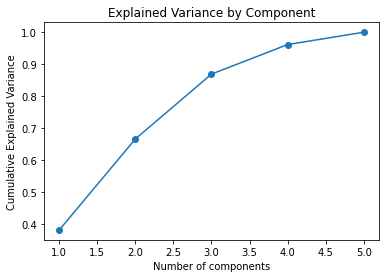

In [75]:
# transform rookie_stats by standard scalar to do PCA analysis
from sklearn.decomposition import PCA

features = [
 'player_age',
 'other_league_exp',
 'player_height_inches',
 'player_weight',
 'draft_group']

rookies_pca = rookie_cluster.loc[:, features].values
rookies_pca
rookies_pca = StandardScaler().fit_transform(rookies_pca)
pca = PCA()
pca.fit(rookies_pca)

# graph to figure out explained variance, where are target goal is to be at 90% explained variance
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o')
plt.title('Explained Variance by Component')
plt.xlabel("Number of components")
plt.ylabel("Cumulative Explained Variance")


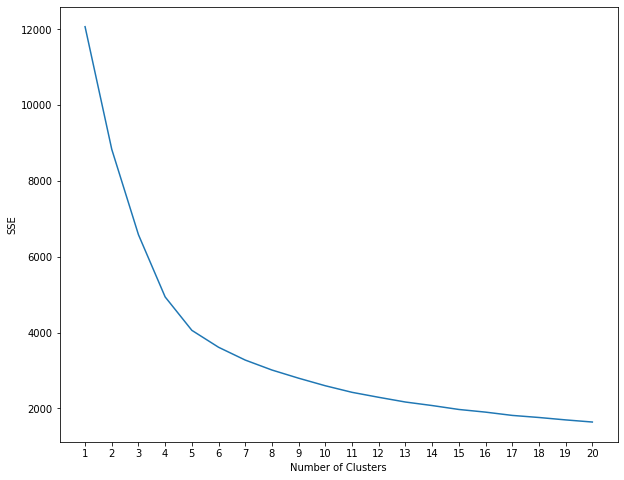

In [76]:
# select 4 n_components based on the graph above
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=4, random_state=42)
scores_pca = pca.fit_transform(rookies_pca)
scores_pca

sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scores_pca)
    sse.append(kmeans.inertia_)


plt.figure(figsize=(10, 8))
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Text(0.5, 1.0, 'Cluster Scatter Plot')

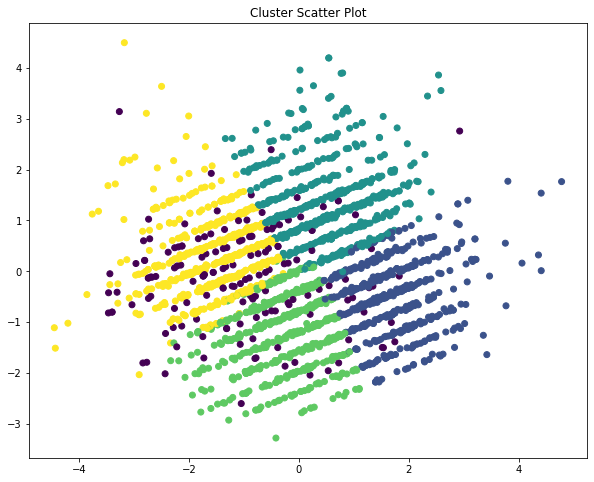

In [77]:
# based on the graph above, see an elbow on 5 clusters

kmeans = KMeans(n_clusters=5, random_state = 420)
label = kmeans.fit_predict(scores_pca)
rookie_cluster['label'] = label

def plot_clusters(X, clusters):
    plt.scatter(X[:, 0], X[:, 1], c=clusters)

plt.figure(figsize=(10,8))
plot_clusters(scores_pca, rookie_cluster['label'])
plt.title("Cluster Scatter Plot")


In [78]:
test2 = rookie_cluster[rookie_cluster["season"] == "2020-21"]
train2 = rookie_cluster[rookie_cluster["season"] != "2020-21"]


In [79]:
# using cluster data, project rookie player ortg, drtg, tot_poss

# predict tot_poss by player
X_train = train2[
    [
        "player_age",
        "draft_group",
        "player_height_inches",
        "player_weight",
        "other_league_exp"
    ]
]
y_train = train2["tot_poss"]

X_test = test2[
    [
        "player_age",
        "draft_group",
        "player_height_inches",
        "player_weight",
        "other_league_exp"
    ]
]
y_test = test2["tot_poss"]

gls = sm.GLS(y_train, X_train)
gls_results = gls.fit()
print(gls_results.summary())

tot_pred = gls_results.predict(X_test)

# using cluster data, project rookie player ortg, drtg, tot_poss

# predict player_ortg by player
X_train = train2[
    [
        "player_age",
        "draft_group",
        "player_height_inches",
        "player_weight",
        "other_league_exp"
    ]
]
y_train = train2["player_ortg"]

X_test = test2[
    [
        "player_age",
        "draft_group",
        "player_height_inches",
        "player_weight",
        "other_league_exp"
    ]
]
y_test = test2["player_ortg"]

gls = sm.GLS(y_train, X_train)
gls_results = gls.fit()
print(gls_results.summary())

player_ortg_pred = gls_results.predict(X_test)



# predict drtg by player
X_train = train2[
    [
        "player_age",
        "draft_group",
        "player_height_inches",
        "player_weight",
        "other_league_exp"
    ]
]
y_train = train2["player_drtg"]

X_test = test2[
    [
        "player_age",
        "draft_group",
        "player_height_inches",
        "player_weight",
        "other_league_exp"
    ]
]
y_test = test2["player_drtg"]

gls = sm.GLS(y_train, X_train)
gls_results = gls.fit()
print(gls_results.summary())

player_drtg_pred = gls_results.predict(X_test)
test2["tot_poss_pred"]=tot_pred
test2["player_ortg_pred"]=player_ortg_pred
test2["player_drtg_pred"]=player_drtg_pred



                                 GLS Regression Results                                
Dep. Variable:               tot_poss   R-squared (uncentered):                   0.618
Model:                            GLS   Adj. R-squared (uncentered):              0.617
Method:                 Least Squares   F-statistic:                              782.2
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                        0.00
Time:                        04:08:22   Log-Likelihood:                         -16882.
No. Observations:                2424   AIC:                                  3.377e+04
Df Residuals:                    2419   BIC:                                  3.380e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [80]:
len(test2)+len(train2)

2511

In [81]:
test.columns.tolist()

test = test[
    [
        "player_name",
        "player_id",
        "team_id",
        "team_abbreviation",
        "season",
        "tot_poss",
        "player_ortg",
        "player_drtg",
        "tot_poss_pred",
        "player_ortg_pred",
        "player_drtg_pred",
    ]
]

test2 = test2[
    [
        "player_name",
        "player_id",
        "team_id",
        "team_abbreviation",
        "season",
        "tot_poss",
        "player_ortg",
        "player_drtg",
        "tot_poss_pred",
        "player_ortg_pred",
        "player_drtg_pred",
    ]
]

train = train[
    [
        "player_name",
        "player_id",
        "team_id",
        "team_abbreviation",
        "season",
        "tot_poss",
        "player_ortg",
        "player_drtg",
    ]
]

train2 = train2[
    [
        "player_name",
        "player_id",
        "team_id",
        "team_abbreviation",
        "season",
        "tot_poss",
        "player_ortg",
        "player_drtg",
    ]
]


test_final = test.append(test2)
train_final = train.append(train2)


test_final_merge = test_final.copy()
test_final_merge["tot_poss"] = test_final_merge["tot_poss_pred"]
test_final_merge["player_ortg"] = test_final_merge["player_ortg_pred"]
test_final_merge["player_drtg"] = test_final_merge["player_drtg_pred"]
test_final_merge = test_final_merge[
    [
        "player_name",
        "player_id",
        "team_id",
        "team_abbreviation",
        "season",
        "tot_poss",
        "player_ortg",
        "player_drtg",
    ]
]


player_data_pred = test_final_merge.append(train_final)
# 16874 - 40
player_stats_total_final = player_data_pred.copy()

# to do
# get tot_poss_team and figure out player_ortg_part etc and check against previous

player_stats_total_final["tot_poss_team"] = player_stats_total_final.groupby(
    ["season", "team_abbreviation", "team_id"]
)["tot_poss"].transform("sum")

player_stats_total_final["tot_percent"] = (
    player_stats_total_final["tot_poss"] / player_stats_total_final["tot_poss_team"]
)


player_stats_total_final["player_ortg_use"] = (
    player_stats_total_final["tot_poss"] / player_stats_total_final["tot_poss_team"]
) * player_stats_total_final["player_ortg"]

player_stats_total_final["player_drtg_use"] = (
    player_stats_total_final["tot_poss"] / player_stats_total_final["tot_poss_team"]
) * player_stats_total_final["player_drtg"]

player_grouped_rating = player_stats_total_final.groupby(["season", "team_id", "team_abbreviation"])[
    "player_ortg_use", "player_drtg_use"
].sum().reset_index()

player_grouped_rating

,season,team_id,team_abbreviation,player_ortg_use,player_drtg_use
0,1985-86,1610612737,ATL,108.241696,105.975954
1,1985-86,1610612738,BOS,112.129177,102.726669
2,1985-86,1610612739,CLE,105.666250,109.025389
3,1985-86,1610612741,CHI,108.755889,112.692645
4,1985-86,1610612742,DAL,112.062187,111.689454
...,...,...,...,...,...
1022,2020-21,1610612762,UTA,109.643716,110.329900
1023,2020-21,1610612763,MEM,100.865163,102.553359
1024,2020-21,1610612764,WAS,103.887030,105.596117
1025,2020-21,1610612765,DET,101.005381,106.073517


In [82]:
player_stats_team1 = player_grouped_rating.rename(
    columns={
        "team_id": "team1_id",
        "team_abbreviation": "team1_abbreviation",
        "player_ortg_use": "team1_ortg_use",
        "player_drtg_use": "team1_drtg_use",
    }
)

player_stats_team2 = player_grouped_rating.rename(
    columns={
        "team_id": "team2_id",
        "team_abbreviation": "team2_abbreviation",
        "player_ortg_use": "team2_ortg_use",
        "player_drtg_use": "team2_drtg_use",
    }
)

player_stats_team2

,season,team2_id,team2_abbreviation,team2_ortg_use,team2_drtg_use
0,1985-86,1610612737,ATL,108.241696,105.975954
1,1985-86,1610612738,BOS,112.129177,102.726669
2,1985-86,1610612739,CLE,105.666250,109.025389
3,1985-86,1610612741,CHI,108.755889,112.692645
4,1985-86,1610612742,DAL,112.062187,111.689454
...,...,...,...,...,...
1022,2020-21,1610612762,UTA,109.643716,110.329900
1023,2020-21,1610612763,MEM,100.865163,102.553359
1024,2020-21,1610612764,WAS,103.887030,105.596117
1025,2020-21,1610612765,DET,101.005381,106.073517


In [83]:
final_df = schedules_final.merge(
    player_stats_team1, on=["season", "team1_id", "team1_abbreviation"], how="left"
)

final_df = final_df.merge(
    player_stats_team2, on=["season", "team2_id", "team2_abbreviation"], how="left"
)

pd.set_option('display.max_columns', None)

# this game was cancelled, remove
final_df = final_df.dropna()
final_df

,season,game_date,game_id,team1_id,team1_abbreviation,team1_name,team1_homeaway,wl,team1_first_game,team1_days_rest,team1_distance_travelled,team2_id,team2_abbreviation,team2_name,team2_homeaway,team2_first_game,team2_days_rest,team2_distance_travelled,winner,winner_home_court,team1_ortg_use,team1_drtg_use,team2_ortg_use,team2_drtg_use
0,1985-86,1985-10-25,28500004,1610612738,BOS,Boston Celtics,away,L,1.0,10.0,235.505411,1.610613e+09,NJN,New Jersey Nets,home,1.0,10.0,0.000000,0,0,112.129177,102.726669,105.438297,107.027459
1,1985-86,1985-10-25,28500005,1610612737,ATL,Atlanta Hawks,home,L,1.0,10.0,0.000000,1.610613e+09,WAS,Washington Bullets,away,1.0,10.0,541.914409,0,1,108.241696,105.975954,103.107969,105.942208
2,1985-86,1985-10-25,28500006,1610612746,LAC,Los Angeles Clippers,away,W,1.0,10.0,361.192935,1.610613e+09,SAC,Sacramento Kings,home,1.0,10.0,0.000000,1,0,105.871404,112.890025,106.525995,109.780242
3,1985-86,1985-10-25,28500007,1610612741,CHI,Chicago Bulls,home,W,1.0,10.0,0.000000,1.610613e+09,CLE,Cleveland Cavaliers,away,1.0,10.0,307.087672,1,1,108.755889,112.692645,105.666250,109.025389
4,1985-86,1985-10-25,28500008,1610612743,DEN,Denver Nuggets,away,W,1.0,10.0,946.622989,1.610613e+09,GOS,Golden State Warriors,home,1.0,10.0,0.000000,1,0,107.238635,106.875960,108.425790,111.718439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41077,2020-21,2021-05-16,22001076,1610612743,DEN,Denver Nuggets,away,L,0.0,1.0,1962.960683,1.610613e+09,POR,Portland Trail Blazers,home,0.0,2.0,1004.107703,0,0,102.805796,104.620751,104.756742,105.013786
41078,2020-21,2021-05-16,22001077,1610612758,SAC,Sacramento Kings,home,L,0.0,1.0,0.000000,1.610613e+09,UTA,Utah Jazz,away,0.0,1.0,1335.214853,0,1,106.820375,108.653594,109.643716,110.329900
41079,2020-21,2021-05-16,22001078,1610612756,PHX,Phoenix Suns,away,W,0.0,0.0,0.000000,1.610613e+09,SAS,San Antonio Spurs,home,0.0,0.0,0.000000,1,0,106.241141,106.961320,102.448626,103.753696
41080,2020-21,2021-05-16,22001079,1610612754,IND,Indiana Pacers,away,W,0.0,0.0,417.900582,1.610613e+09,TOR,Toronto Raptors,home,0.0,1.0,1202.513604,1,0,104.106429,105.878147,107.322354,108.685155


Split the training and test data based on seasons, where the last season of the dataset will be used for testing

X variables:
    "days_rest_home",
    "dist_mile_home",
    "team_off_load_home_avg",
    "days_rest_away",
    "dist_mile_away",
    "team_off_load_away_avg"
    
Y variable:
    "winner"

winner = 1 if home team wins, winner = 0 if away team wins

In [84]:
final_df.columns.tolist()

['season',
 'game_date',
 'game_id',
 'team1_id',
 'team1_abbreviation',
 'team1_name',
 'team1_homeaway',
 'wl',
 'team1_first_game',
 'team1_days_rest',
 'team1_distance_travelled',
 'team2_id',
 'team2_abbreviation',
 'team2_name',
 'team2_homeaway',
 'team2_first_game',
 'team2_days_rest',
 'team2_distance_travelled',
 'winner',
 'winner_home_court',
 'team1_ortg_use',
 'team1_drtg_use',
 'team2_ortg_use',
 'team2_drtg_use']

In [85]:
# split the train and test based on seasons, where the last season of the dataset will be used for testing
train = final_df[final_df["season"] != "2020-21"]
test = final_df[final_df["season"] == "2020-21"]

X_train = train[
    [
        "team1_first_game",
        "team1_days_rest",
        "team1_distance_travelled",
        "team1_ortg_use",
        "team1_drtg_use",
        "team2_first_game",
        "team2_days_rest",
        "team2_distance_travelled",
        "team2_ortg_use",
        "team2_drtg_use",
        "winner_home_court",
    ]
]

y_train = train["winner"]

X_test = test[
    [
        "team1_first_game",
        "team1_days_rest",
        "team1_distance_travelled",
        "team1_ortg_use",
        "team1_drtg_use",
        "team2_first_game",
        "team2_days_rest",
        "team2_distance_travelled",
        "team2_ortg_use",
        "team2_drtg_use",
        "winner_home_court",
    ]
]

y_test = test["winner"]

# Setup Baseline Using Logistic Regression

For regularization method, determine if L1, L2, or elastic net is appropriate. Initial assumption is that Ridge(L2) will be better since there are not that many variables to deal with. For elasticnet, set the ratio of l1_ratio = 0.5 for now. For $ c = 1/\lambda $, use cross validation of 10 folds.

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [87]:
# print summary of logistic regression

import statsmodels.api as sm


logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(logit_model.summary())

# According to the summary, it seems that distance travelled and first games are not signification
# fail to reject null

Optimization terminated successfully.
         Current function value: 0.568213
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                40001
Model:                          Logit   Df Residuals:                    39989
Method:                           MLE   Df Model:                           11
Date:                Sun, 24 Apr 2022   Pseudo R-squ.:                  0.1802
Time:                        04:08:25   Log-Likelihood:                -22729.
converged:                       True   LL-Null:                       -27727.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9178      0.509     -1.804      0.071      -1.915

In [88]:
# split the train and test based on seasons, where the last season of the dataset will be used for testing
train = final_df[final_df["season"] != "2020-21"]
test = final_df[final_df["season"] == "2020-21"]

X_train = train[
    [
        "team1_first_game",
        "team1_days_rest",
        "team1_ortg_use",
        "team1_drtg_use",
        "team2_days_rest",
        "team2_ortg_use",
        "team2_drtg_use",
        "winner_home_court",
    ]
]

y_train = train["winner"]

X_test = test[
    [
        "team1_first_game",
        "team1_days_rest",
        "team1_ortg_use",
        "team1_drtg_use",
        "team2_days_rest",
        "team2_ortg_use",
        "team2_drtg_use",
        "winner_home_court",
    ]
]

y_test = test["winner"]

In [ ]:
# use gridsearchcv in order to select best hyperparameters

# define model logistic regression
lg = LogisticRegression(max_iter = 400)

# create a space for hyper parameters
space = dict()
space["solver"] = ["newton-cg", "lbfgs", "liblinear", "saga"]
space["penalty"] = ["l1", "l2", "elasticnet"]
space["C"] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define gridsearchcv with all the parameters
search = GridSearchCV(lg, space, scoring="accuracy", cv=10)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print("Best Score: %s" % result.best_score_)
print("Best Hyperparameters: %s" % result.best_params_)

In [89]:
# based on the results above, the best parameters are 
lg = LogisticRegression(C= 100, penalty = 'l2', solver = 'lbfgs', max_iter = 400)
lg.fit(X_train, y_train)
predict_labels = lg.predict(X_test)
print("Accuracy of logistic regression is {}".format(sum(predict_labels==y_test)/len(y_test)))


Accuracy of logistic regression is 0.5444444444444444


In [90]:
logreg = test.copy()
logreg["predict"] = predict_labels
logreg

# count the number of wins by team
logreg["win_actual"] = np.where(
    logreg["winner"] == 1, logreg["team1_abbreviation"], logreg["team2_abbreviation"]
)
logreg["win_predicted"] = np.where(
    logreg["predict"] == 1, logreg["team1_abbreviation"], logreg["team2_abbreviation"]
)


actual_result = logreg["win_actual"].value_counts()
logreg_result = logreg["win_predicted"].value_counts()
display(actual_result, logreg_result)

UTA    52
PHX    51
PHI    49
BKN    48
DEN    47
LAC    47
MIL    46
POR    42
LAL    42
DAL    42
ATL    41
NYK    41
MIA    40
GSW    39
MEM    38
BOS    36
WAS    34
IND    34
CHA    33
SAS    33
NOP    31
SAC    31
CHI    31
TOR    27
MIN    23
OKC    22
CLE    22
ORL    21
DET    20
HOU    17
Name: win_actual, dtype: int64

BKN    44
LAL    43
LAC    40
MIL    40
PHX    39
UTA    39
POR    39
BOS    38
PHI    38
WAS    38
HOU    37
TOR    37
SAC    36
IND    36
MIA    36
ATL    36
DEN    36
DAL    36
MEM    36
CHI    36
NOP    36
SAS    35
CHA    34
NYK    34
ORL    34
OKC    33
MIN    32
CLE    32
GSW    29
DET    21
Name: win_predicted, dtype: int64

Based on the results above, the logistic regression did not converge (which might indicate that the win prediction is not linearly separable data)

# Other Model Approaches (Random Forest Classificiation, XGBoost Classification)

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing


In [67]:
rfc=RandomForestClassifier(random_state=42)

space = dict()
# The number of trees in the forest
space["n_estimators"] = list(range(10,200))

# The maximum depth of the tree
space["max_depth"] = list(range(1,21))
space['max_features']: ['auto', 'sqrt', 'log2']
space["criterion"] = ['gini', 'entropy']



# define RandomizedSearch with all the parameters
search = RandomizedSearchCV(rfc, space, scoring="accuracy", cv=10)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print("Best Score: %s" % result.best_score_)
print("Best Hyperparameters: %s" % result.best_params_)

Best Score: 0.6918572169457635
Best Hyperparameters: {'n_estimators': 140, 'max_depth': 8, 'criterion': 'gini'}


In [92]:
# based on gridsearch above, the best parameters are entropy with max_depth of 10 and n_est of 200
rfc = RandomForestClassifier(random_state=42, criterion = "gini", max_depth = 8, n_estimators = 140)
rfc.fit(X_train, y_train)
predict_labels = rfc.predict(X_test)
print("Accuracy of random forest classification is {}".format(sum(predict_labels==y_test)/len(y_test)))




Accuracy of random forest classification is 0.5564814814814815


In [93]:
randomforest = test.copy()
randomforest["predict"] = predict_labels
randomforest

# count the number of wins by team
randomforest["win_predicted"] = np.where(
    randomforest["predict"] == 1,
    randomforest["team1_abbreviation"],
    randomforest["team2_abbreviation"],
)


randomforest_result = randomforest["win_predicted"].value_counts()
display(actual_result, randomforest_result)

UTA    52
PHX    51
PHI    49
BKN    48
DEN    47
LAC    47
MIL    46
POR    42
LAL    42
DAL    42
ATL    41
NYK    41
MIA    40
GSW    39
MEM    38
BOS    36
WAS    34
IND    34
CHA    33
SAS    33
NOP    31
SAC    31
CHI    31
TOR    27
MIN    23
OKC    22
CLE    22
ORL    21
DET    20
HOU    17
Name: win_actual, dtype: int64

POR    45
LAL    43
UTA    42
BKN    41
SAS    39
LAC    39
MIL    39
PHI    38
DAL    38
PHX    38
NOP    37
HOU    37
WAS    37
BOS    36
DEN    36
IND    36
MIA    36
MEM    36
NYK    35
ATL    35
CHA    35
TOR    35
ORL    35
CHI    35
MIN    34
CLE    33
OKC    32
DET    29
SAC    29
GSW    20
Name: win_predicted, dtype: int64

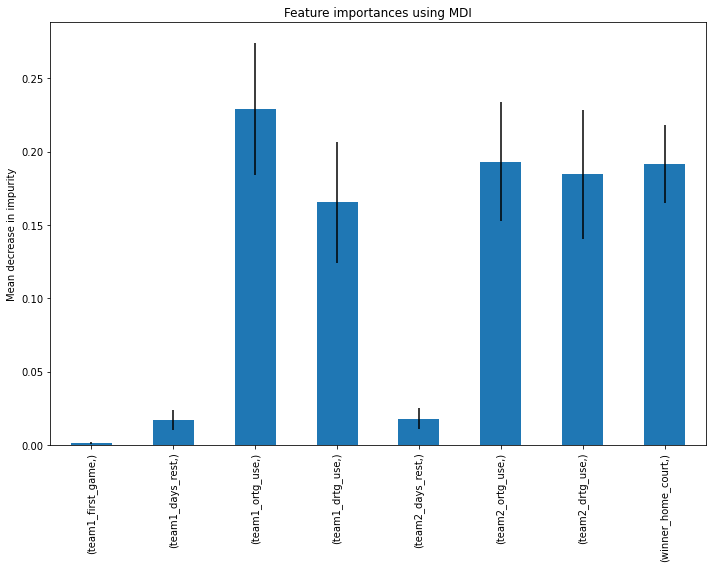

In [94]:
# graph feature importance for random forest

feature_names = [X_train.columns.tolist()]

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# these features are most important in explaining the target variable
# which means that team1_ortg and team2_ortg would be highest (root) of the decision tree

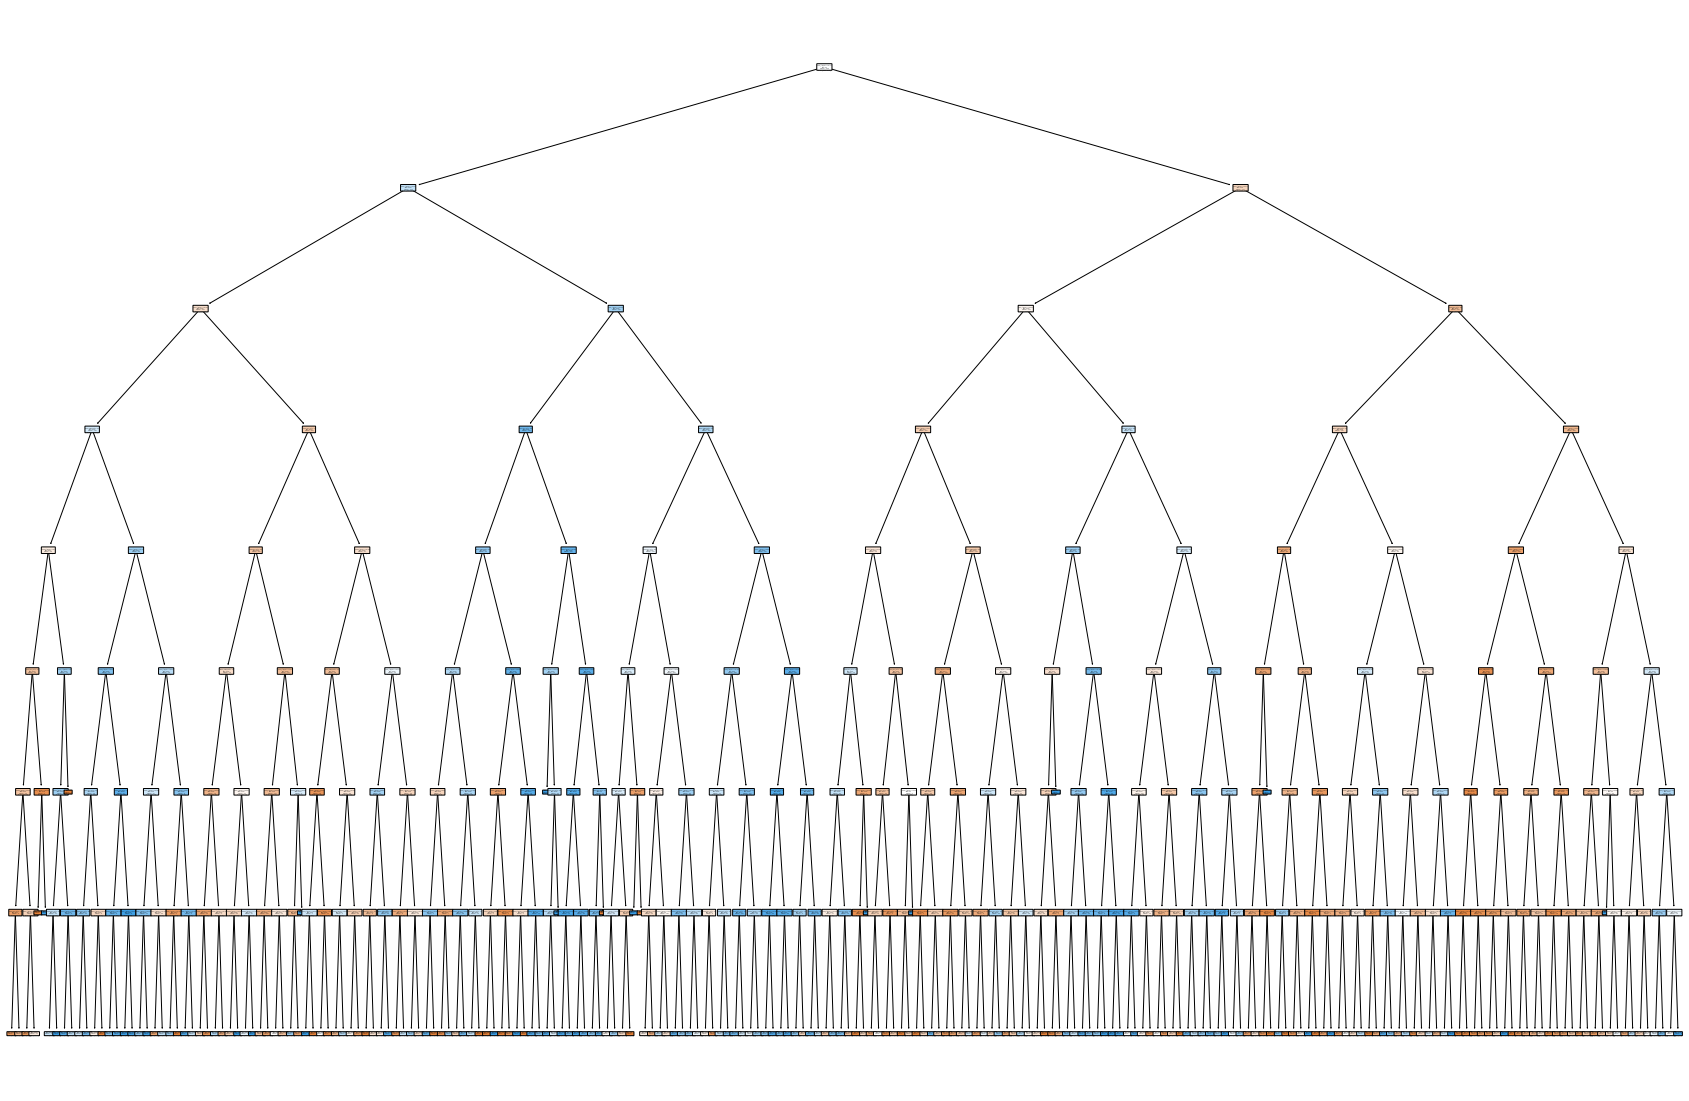

In [95]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(30, 20))
plot_tree(rfc.estimators_[0], 
          feature_names=X_train.columns.tolist(),
          filled=True, impurity=True, 
          rounded=True)

fig.savefig('rf_individualtree.png')

In [96]:
# XGB classifier
from xgboost import XGBClassifier

xgb = XGBClassifier()

scores = cross_val_score(xgb, X_train, y_train, cv=10, scoring="accuracy")


In [97]:
# report performance
print("Accuracy: ", scores.mean())

Accuracy:  0.6695324981254686


In [98]:
xgb.fit(X_train, y_train)
predict_labels = xgb.predict(X_test)


In [99]:
print(
    "Accuracy of XGBoost classification is {}".format(
        sum(predict_labels == y_test) / len(y_test)
    )
)

Accuracy of XGBoost classification is 0.5592592592592592


In [100]:
xgboost = test.copy()
xgboost["predict"] = predict_labels
xgboost

# count the number of wins by team
xgboost["win_predicted"] = np.where(
    xgboost["predict"] == 1,
    xgboost["team1_abbreviation"],
    xgboost["team2_abbreviation"],
)


xgboost_result = xgboost["win_predicted"].value_counts()
display(actual_result, xgboost_result)

UTA    52
PHX    51
PHI    49
BKN    48
DEN    47
LAC    47
MIL    46
POR    42
LAL    42
DAL    42
ATL    41
NYK    41
MIA    40
GSW    39
MEM    38
BOS    36
WAS    34
IND    34
CHA    33
SAS    33
NOP    31
SAC    31
CHI    31
TOR    27
MIN    23
OKC    22
CLE    22
ORL    21
DET    20
HOU    17
Name: win_actual, dtype: int64

LAL    55
SAS    50
UTA    48
BKN    45
CHI    45
POR    43
PHX    42
MIA    42
LAC    42
HOU    40
IND    40
MIL    39
BOS    37
WAS    36
MEM    36
DEN    36
PHI    36
SAC    35
DAL    35
MIN    32
TOR    32
ORL    32
ATL    31
NYK    29
NOP    28
CLE    25
CHA    24
DET    23
GSW    22
OKC    20
Name: win_predicted, dtype: int64

# Result

In [101]:
result_comparison = pd.DataFrame(
    {
        "Actual Wins": actual_result,
        "Logistic Regression Wins": logreg_result,
        "Random Forest Wins": randomforest_result,
        "XGBoost Wins": xgboost_result,
        "Actual - Logistic": actual_result - logreg_result,
        "Actual - Random Forest": actual_result - randomforest_result,
        "Actual - XGBoost": actual_result - xgboost_result,
    }
)

display(result_comparison)

,Actual Wins,Logistic Regression Wins,Random Forest Wins,XGBoost Wins,Actual - Logistic,Actual - Random Forest,Actual - XGBoost
ATL,41,36,35,31,5,6,10
BKN,48,44,41,45,4,7,3
BOS,36,38,36,37,-2,0,-1
CHA,33,34,35,24,-1,-2,9
CHI,31,36,35,45,-5,-4,-14
CLE,22,32,33,25,-10,-11,-3
DAL,42,36,38,35,6,4,7
DEN,47,36,36,36,11,11,11
DET,20,21,29,23,-1,-9,-3
GSW,39,29,20,22,10,19,17
